In [2]:
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

import matplotlib
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('C:\\Users\\dlfdus\\PycharmProjects\\mypacakge\\')
from corpus import DoublespaceLineCorpus
from corpus import DoublespaceLineCorpusWithList
from tqdm import tqdm_notebook
import requests
import pandas as pd
import re
import pickle
from collections import Counter

In [4]:
import gensim
from scipy.io import mmwrite, mmread

tokenized_corpus_fname = 'data/tmp/doc2vec_word_data.txt' 

C:\Users\dlfdus\Anaconda3\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
corpus_ = open(tokenized_corpus_fname, 'r')
line = corpus_.readlines()

In [6]:
line[:5]

['(주)하나투어\t업계 1위 하나투어 인정 많음 여행사 친구들 연봉 복지 좋음 \n',
 '(주)하나투어\t여행 혜택 연차 사용 있음 가족 균형 측면 좋음 \n',
 '(주)하나투어\t연차 회사 커뮤니케이션 \n',
 '(주)하나투어\t브랜드 1위 저녁 여행 할인 \n',
 '(주)하나투어\t있음 업무 찾기 힘듬 \n']

In [7]:
reviews = []
for idx, i in enumerate(line):
    temp = i.split('\t')[1]
    temp = re.sub('\n', '', temp)
    reviews.append(temp)

In [8]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

def TaggedReview(reviews):
    for doc in reviews:
        company_tag, review = doc.split('\t')
        text = re.sub('\n', '', review)
        yield TaggedDocument(words=text.split(), tags=['Company_%s' % company_tag])

doc2vec_corpus = list(TaggedReview(line))

In [9]:
for num_doc, doc in enumerate(doc2vec_corpus):
    if num_doc > 5: break
    print(doc)

TaggedDocument(['업계', '1위', '하나투어', '인정', '많음', '여행사', '친구들', '연봉', '복지', '좋음'], ['Company_(주)하나투어'])
TaggedDocument(['여행', '혜택', '연차', '사용', '있음', '가족', '균형', '측면', '좋음'], ['Company_(주)하나투어'])
TaggedDocument(['연차', '회사', '커뮤니케이션'], ['Company_(주)하나투어'])
TaggedDocument(['브랜드', '1위', '저녁', '여행', '할인'], ['Company_(주)하나투어'])
TaggedDocument(['있음', '업무', '찾기', '힘듬'], ['Company_(주)하나투어'])
TaggedDocument(['연차', '사용', '비교적', '회사', '복지', '거점', '운영', '시차', '근무', '재택근무', '직원', '제공', '상품', '직원', '이용', '가능', '분위기', '정시퇴근', '승진', '어려움', '없음'], ['Company_(주)하나투어'])


In [10]:
train_Doc2Vec = False

In [11]:
%%time
doc2vec_fname = 'data/tmp/doc2vec_model.pkl' 
if train_Doc2Vec:
    doc2vec_model = Doc2Vec(doc2vec_corpus, size=200, alpha=0.05, window=5, min_count=5, negative=5) 
    with open(doc2vec_fname, 'wb') as f:
        pickle.dump(doc2vec_model, f)

else:
    with open(doc2vec_fname, 'rb') as f:
        doc2vec_model = pickle.load(f)

Wall time: 341 ms


In [12]:
doc2vec_model.docvecs.doctag_syn0.shape, type(doc2vec_model.docvecs.doctag_syn0)

((654, 200), numpy.ndarray)

In [13]:
index2tag = [doc2vec_model.docvecs.index_to_doctag(i) for i in range(654)]
print(index2tag[:5])

tag2index = {tag:index for index, tag in enumerate(index2tag)}

['Company_(주)하나투어', 'Company_호텔신라(주)', 'Company_대명레저산업(주)', 'Company_이랜드파크(주)', 'Company_모두투어네트워크(주)']


In [14]:
index2name = []

for i in index2tag:
    index2name.append(i.split('_')[1])
print(index2name[:5])

['(주)하나투어', '호텔신라(주)', '대명레저산업(주)', '이랜드파크(주)', '모두투어네트워크(주)']


In [15]:
Train_TSNE = False

In [16]:
%%time 
if Train_TSNE == True:
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, perplexity=30, method='barnes_hut')
    y_tsne = tsne.fit_transform(doc2vec_model.docvecs.doctag_syn0)
    
    with open('data/tmp/doc2vec2tsne.pkl', 'wb') as f:
        pickle.dump(y_tsne, f)
else:
    with open('data/tmp/doc2vec2tsne.pkl', 'rb') as f:
        y_tsne = pickle.load(f)

Wall time: 40.9 ms


In [17]:
y_tsne = pd.DataFrame(data=y_tsne, columns=['1','2'])

In [18]:
def get_similars(company, topn=10):
    
    plt.figure(figsize=(18,12))
    #plt.scatter(y_tsne[:,0], y_tsne[:,1], color='blue')
    cmap = sns.color_palette(['blue'])
    ax = sns.scatterplot(x='1', y='2',sizes=(20, 300), data=y_tsne)
    similars = [tag for tag, _ in doc2vec_model.docvecs.most_similar(company, topn=topn)] + [company]
    #cmap = sns.color_palette(['blue'])
    #ax = sns.scatterplot(data=y_tsne)
    for idx, i in enumerate(doc2vec_model.docvecs.most_similar(company)):
        print(idx, i)
    for tag in similars:
        index = tag2index.get(tag, -1)
        if index == -1:
            continue
        name = index2name[index]
        plt.annotate(name, (y_tsne.loc[index, '1'], y_tsne.loc[index, '2']))
        matplotlib.rcParams.update({'font.size': 10})
    plt.show()

0 ('Company_한국씨티은행(주)', 0.7856536507606506)
1 ('Company_홍콩상하이은행', 0.7460617423057556)
2 ('Company_한국로버트보쉬(주)', 0.695363461971283)
3 ('Company_보쉬전장(주)', 0.6866298913955688)
4 ('Company_오렌지라이프생명보험(주)', 0.6706101894378662)
5 ('Company_지멘스(주)', 0.666904866695404)
6 ('Company_우리은행(주)', 0.6298515796661377)
7 ('Company_디에이치엘코리아(주)', 0.6104341745376587)
8 ('Company_한국지엠(주)', 0.6049787998199463)
9 ('Company_한국마이크로소프트(유)', 0.6012301445007324)


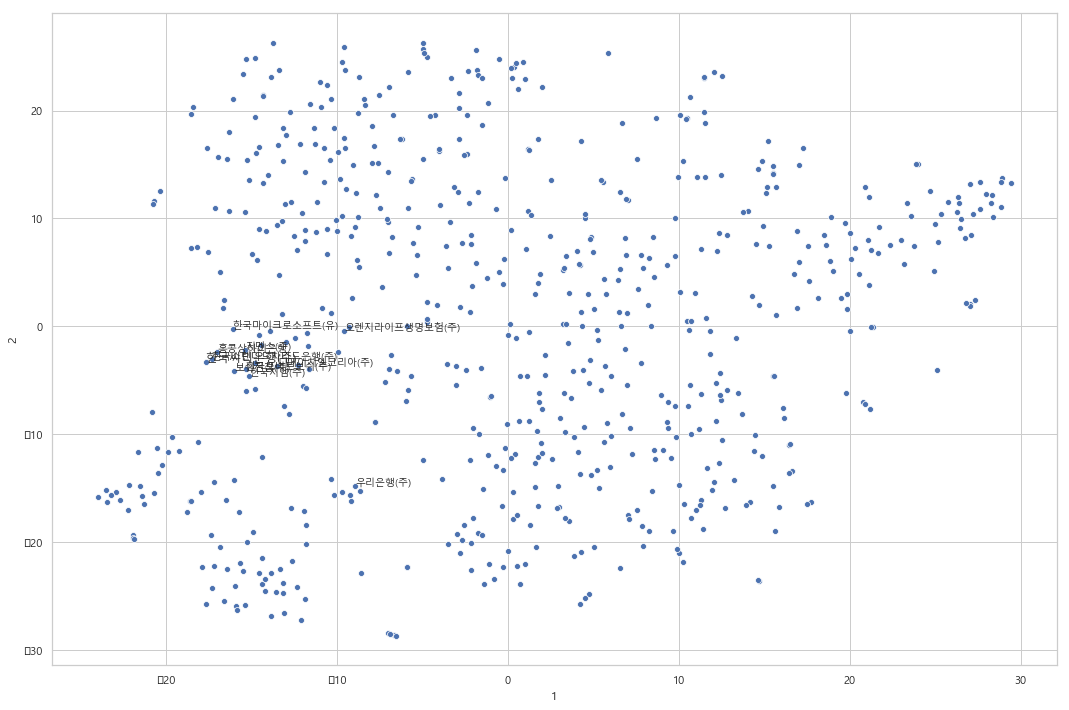

In [19]:
get_similars('Company_한국스탠다드차타드은행(주)', topn=10)

0 ('Company_에스케이하이닉스(주)', 0.761228084564209)
1 ('Company_삼성디스플레이(주)', 0.6812166571617126)
2 ('Company_엘지디스플레이(주)', 0.6745253801345825)
3 ('Company_삼성전기(주)', 0.6604739427566528)
4 ('Company_삼성에스디에스(주)', 0.6536863446235657)
5 ('Company_엘지전자(주)', 0.6331568956375122)
6 ('Company_세메스(주)', 0.6082856059074402)
7 ('Company_씨제이제일제당(주)', 0.5854981541633606)
8 ('Company_삼성바이오로직스(주)', 0.5767762064933777)
9 ('Company_삼성카드(주)', 0.5661366581916809)


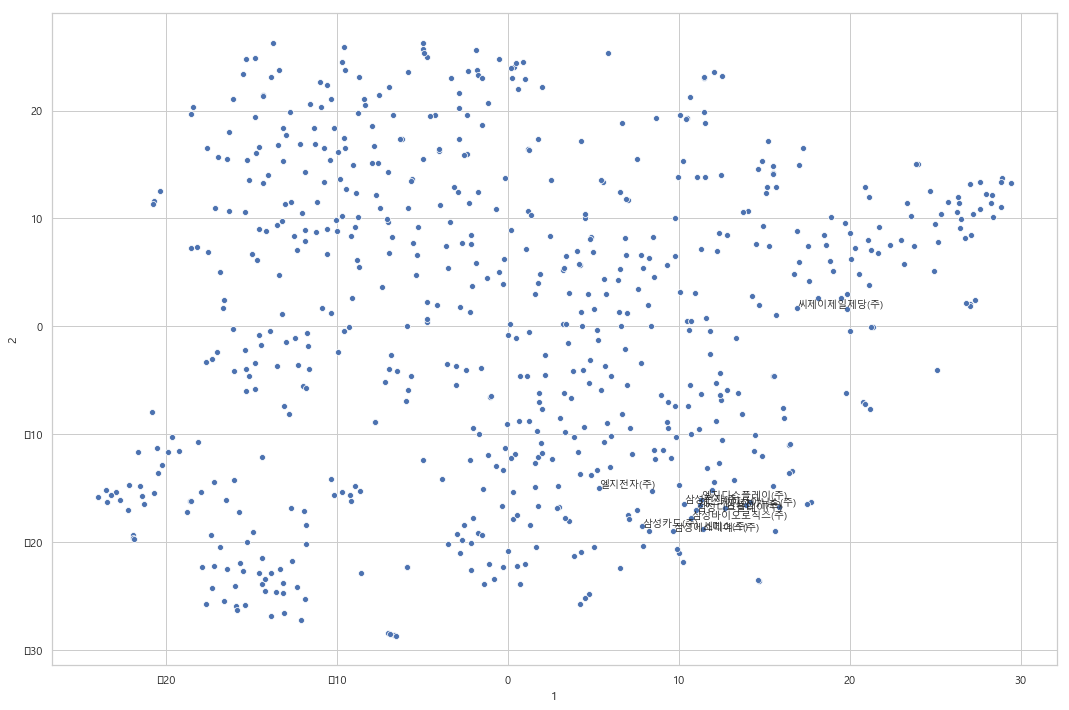

In [20]:
get_similars('Company_삼성전자(주)', topn=10)

In [23]:
doc2vec_model.wv['복지'].shape

(200,)

In [24]:
doc2vec_model.wv.most_similar('복지', topn=10)

[('복리후생', 0.8032820820808411),
 ('복리', 0.6278481483459473),
 ('사내복지', 0.5663562417030334),
 ('감면', 0.5067119598388672),
 ('우리사주', 0.4787592887878418),
 ('무용지물', 0.46911725401878357),
 ('중위권', 0.46747124195098877),
 ('어학지원', 0.4656369090080261),
 ('포상', 0.4599837362766266),
 ('떡값', 0.4585900604724884)]

In [25]:
doc2vec_model.wv.most_similar_cosmul(positive=['연봉', '복지'], negative=['계약직'], topn=10)

[('복리', 0.9989481568336487),
 ('초봉', 0.9468761682510376),
 ('복리후생', 0.9397227168083191),
 ('물가', 0.9271640777587891),
 ('보상체계', 0.9238326549530029),
 ('나은편', 0.9112371206283569),
 ('임금', 0.8959813714027405),
 ('중위권', 0.8901846408843994),
 ('급여', 0.8833688497543335),
 ('인상률', 0.880065381526947)]

In [26]:
doc2vec_model.docvecs.most_similar('Company_한국필립모리스(주)', topn=10)

[('Company_한국마이크로소프트(유)', 0.7636823654174805),
 ('Company_한국로버트보쉬(주)', 0.740320086479187),
 ('Company_한국지엠(주)', 0.6972159147262573),
 ('Company_한국아이비엠(주)', 0.6965687274932861),
 ('Company_지멘스(주)', 0.6751603484153748),
 ('Company_한국화이자제약(주)', 0.6744371652603149),
 ('Company_한국피앤지판매(유)', 0.6739020943641663),
 ('Company_한국휴렛팩커드(유)', 0.663619875907898),
 ('Company_메타넷글로벌(유)', 0.6630514860153198),
 ('Company_라인플러스(주)', 0.6263917684555054)]

In [27]:
doc2vec_model.docvecs.most_similar(positive=['Company_한국스탠다드차타드은행(주)', 'Company_(주)엔씨소프트'], negative=['Company_현대중공업(주)'], topn=10)

[('Company_로레알코리아', 0.6672307848930359),
 ('Company_한국화이자제약(주)', 0.6550122499465942),
 ('Company_이베이코리아(주)', 0.6222190856933594),
 ('Company_이엘씨에이한국(유)', 0.607144296169281),
 ('Company_엘브이엠에치코스메틱스(유)', 0.6010435819625854),
 ('Company_한국암웨이(주)', 0.588209867477417),
 ('Company_아모레퍼시픽(주)', 0.5832533836364746),
 ('Company_입소스코리아(주)', 0.5607964396476746),
 ('Company_에이치앤엠헤네스앤모리츠(주)', 0.5562105178833008),
 ('Company_부루벨코리아(주)', 0.5555568933486938)]

In [28]:
doc2vec_model.wv.most_similar_cosmul(positive=['연봉', '복지'], negative=['계약직'], topn=10)

[('복리', 0.9989481568336487),
 ('초봉', 0.9468761682510376),
 ('복리후생', 0.9397227168083191),
 ('물가', 0.9271640777587891),
 ('보상체계', 0.9238326549530029),
 ('나은편', 0.9112371206283569),
 ('임금', 0.8959813714027405),
 ('중위권', 0.8901846408843994),
 ('급여', 0.8833688497543335),
 ('인상률', 0.880065381526947)]

In [21]:
from sklearn.preprocessing import normalize
company_vectors = normalize(doc2vec_model.docvecs.doctag_syn0, axis=1, norm='l2')

In [24]:
company_vectors[0].shape

(200,)

In [30]:
%%time

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, max_iter=10, n_init=1, verbose=0)
print('kmeans.fit_predict() was done')
clusters = kmeans.fit_predict(company_vectors)

print('\nkmeans.fit_transform() was done\n')
distance = kmeans.fit_transform(company_vectors)

kmeans.fit_predict() was done

kmeans.fit_transform() was done

Wall time: 4.39 s


In [31]:
from collections import defaultdict

cluster_to_row = defaultdict(lambda: [])
for row_id, label in enumerate(clusters):
    cluster_to_row[label].append(row_id)
    
cluster_to_row = dict(cluster_to_row)
for label, rows in cluster_to_row.items():
    print('cluster # %d has %d companies' % (label, len(rows)))

cluster # 0 has 58 companies
cluster # 1 has 62 companies
cluster # 2 has 52 companies
cluster # 3 has 47 companies
cluster # 4 has 61 companies
cluster # 5 has 92 companies
cluster # 6 has 65 companies
cluster # 7 has 107 companies
cluster # 8 has 75 companies
cluster # 9 has 35 companies


In [32]:
row2company = sorted(doc2vec_model.docvecs.doctags.items(), key=lambda x:x[1].offset)
print(row2company[:3], '\n')
row2company = [row[0].split('_')[1] for row in row2company]
print(row2company[:3], '\n')

[('Company_(주)하나투어', Doctag(offset=0, word_count=1874, doc_count=200)), ('Company_호텔신라(주)', Doctag(offset=1, word_count=1928, doc_count=200)), ('Company_대명레저산업(주)', Doctag(offset=2, word_count=2515, doc_count=200))] 

['(주)하나투어', '호텔신라(주)', '대명레저산업(주)'] 



In [33]:
data = pd.read_csv('data/reviews/회사리뷰.csv')

In [34]:
company = row2company
industry_field_1 = data['1차산업군'].unique()
industry_field_2 = data['2차산업군'].unique()

company_IF = pd.DataFrame()
company_IF['회사명'] = company

field1list, field2list = [],[]
for i in company:
    temp = data[data['회사명']==i].reset_index(drop=True)
    field1 = temp.loc[0, '1차산업군']
    field2 = temp.loc[0, '2차산업군']
    field1list.append(field1)
    field2list.append(field2)
    
company_IF['1차산업군'] = field1list
company_IF['2차산업군'] = field2list

In [35]:
company_IF.tail()

,회사명,1차산업군,2차산업군
649,한국교육개발원,기관/협회,연구소/컨설팅/조사
650,딜로이트컨설팅(유),기관/협회,연구소/컨설팅/조사
651,한국원자력연구원,기관/협회,연구소/컨설팅/조사
652,마콜컨설팅그룹(주),기관/협회,연구소/컨설팅/조사
653,더보스톤컨설팅그룹인터내셔날인크,기관/협회,연구소/컨설팅/조사


In [36]:
with open('data/tmp/company_IF.pkl', 'wb') as f:
        pickle.dump(company_IF, f)

In [37]:
for label, rows in cluster_to_row.items():
    print('\ncluster # %d' % label)
    for row in rows[:10]:
        print(' > {} - {} - {}'.format(company_IF.loc[row, '회사명'],company_IF.loc[row, '1차산업군'],company_IF.loc[row, '2차산업군']))


cluster # 0
 > (주)대학내일 - 서비스업 - 기타
 > 아모레퍼시픽(주) - 제조/화학 - 석유/화학/에너지
 > 엘지생활건강(주) - 제조/화학 - 석유/화학/에너지
 > 애경산업(주) - 제조/화학 - 석유/화학/에너지
 > 풀무원식품(주) - 제조/화학 - 식품가공/개발
 > 세아상역(주) - 제조/화학 - 섬유/의류/패션
 > (주)엘에프 - 제조/화학 - 섬유/의류/패션
 > 한섬(주) - 제조/화학 - 섬유/의류/패션
 > (주)셀트리온 - 의료/제약/복지 - 제약/보건/바이오
 > 이랜드리테일(주) - 유통/무역/운송 - 판매유통

cluster # 1
 > 케이텍맨파워(주) - 서비스업 - 시설관리/용역/헤드헌팅
 > 엘지이노텍(주) - 제조/화학 - 전기/전자/제어
 > 팬택(주) - 제조/화학 - 전기/전자/제어
 > 한국단자공업(주) - 제조/화학 - 전기/전자/제어
 > 코리아써키트(주) - 제조/화학 - 전기/전자/제어
 > 히로세코리아(주) - 제조/화학 - 전기/전자/제어
 > (주)케이엠더블유 - 제조/화학 - 전기/전자/제어
 > 네패스(주) - 제조/화학 - 전기/전자/제어
 > (주)인터플렉스 - 제조/화학 - 전기/전자/제어
 > (주)심텍홀딩스 - 제조/화학 - 전기/전자/제어

cluster # 2
 > 맨파워코리아(주) - 서비스업 - 시설관리/용역/헤드헌팅
 > 홍콩상하이은행 - 제조/화학 - 전기/전자/제어
 > (주)에이비비코리아 - 제조/화학 - 전기/전자/제어
 > 한국에스지에스(주) - 제조/화학 - 석유/화학/에너지
 > 오비맥주(주) - 제조/화학 - 식품가공/개발
 > 에이에스엠엘코리아(주) - 제조/화학 - 반도체/광학/디스플레이
 > 한세실업(주) - 제조/화학 - 섬유/의류/패션
 > 한국지엠(주) - 제조/화학 - 기계/설비/자동차
 > 한국로버트보쉬(주) - 제조/화학 - 기계/설비/자동차
 > 콘티넨탈오토모티브일렉트로닉스(유) - 제조/화학 - 기계/설비/자동차

cluster 

In [ ]:
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

sns.set(style="ticks")
sns.set_style('whitegrid')
sns.set_color_codes()

import matplotlib
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib.pyplot as plt

In [80]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
cluster_tsne = tsne.fit_transform(kmeans.cluster_centers_)
cluster_tsne = cluster_tsne*1000

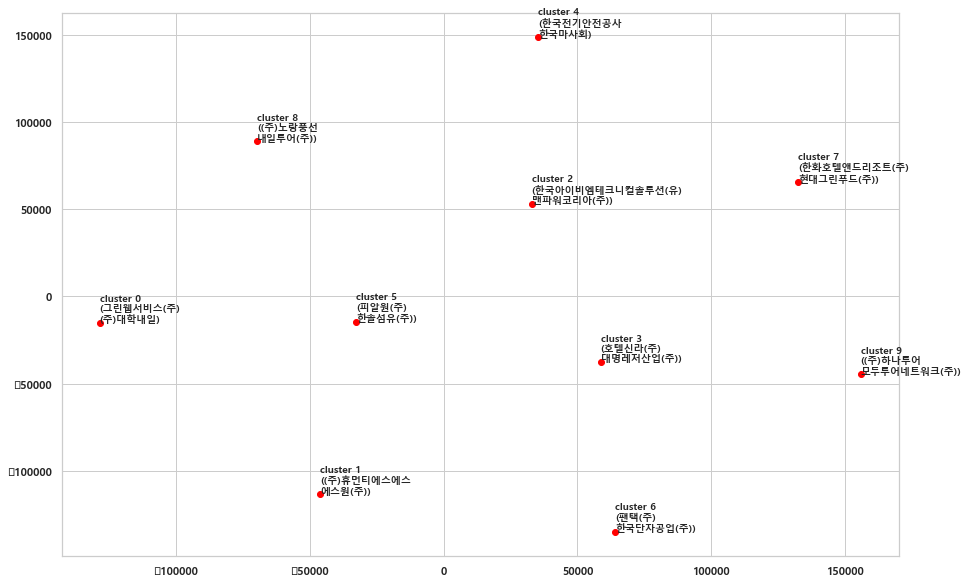

In [82]:
plt.figure(figsize=(15,10))
plt.scatter(cluster_tsne[:,0], cluster_tsne[:,1], color='red')
for i in range(cluster_tsne.shape[0]):
    one_sample = row2company[cluster_to_row[i][0]]
    two_sample = row2company[cluster_to_row[i][1]]
    plt.annotate('cluster %d \n(%s\n%s)' % (i, one_sample, two_sample), 
                 (cluster_tsne[i, 0], cluster_tsne[i, 1])
                )
plt.show()